## Importing Libraries

In [102]:
import cv2
import glob
import numpy as np
from PIL import Image
from matplotlib import cm
import pickle as pkl

In [103]:
import torch

## Loading the Training Data(pre-processed by project_detection.py and project_datasplitting.py)

In [104]:
classes = 15

In [186]:
#Reference: https://pynative.com/python-glob#:~:text=The%20glob%20module%2C%20part%20of,Unix%20Shell%20path%20expansion%20rules
names=[]
imgs=[]
labels=[]
#Making an array for the names of all the images in the training set
for i in range(classes):
    s = "face"+str(i+1)
    #my_imgs=[]
    for img in glob.glob("Data/Celebs_15_Training_and_Validation/train/"+s+"/*.jpg"):
        #Glob returns paths of images of the folder in a randomised order
        a=cv2.imread(img)
        f = cv2.resize(a, (64,64))
        imgs.append(torch.from_numpy(f))
        names.append(s)
        labels.append(torch.tensor(i))
        #cv2.imshow('image',f)

        #Extracting and appending the names to the array from the file paths
    #imgs_per_name.append(my_imgs)
    #names.append(s)
print(len(names))
#print(names)
print(len(imgs))
print(imgs[0].shape)
print(type(imgs))
print(type(imgs[0]))
#im = Image.fromarray(np.uint8(imgs[1]))
#im.show()
#print(imgs[0])
#Size of train dataset

568
568
torch.Size([64, 64, 3])
<class 'list'>
<class 'torch.Tensor'>


In [187]:

imgs_train = torch.stack(imgs, 0)
labels_train = torch.stack(labels, 0)
#print(imgs.shape)
#print(imgs.shape)
imgs_train = imgs_train.permute(0,3,1,2)
imgs_train = imgs_train.float()

## Loading the Testing Data

In [188]:
#Reference: https://pynative.com/python-glob#:~:text=The%20glob%20module%2C%20part%20of,Unix%20Shell%20path%20expansion%20rules
imgs_test=[]
labels_t=[]
#Making an array for the names of all the images in the training set
for i in range(classes):
    s = "face"+str(i+1)
    #my_imgs=[]
    for img in glob.glob("Data/Celebs_15_Training_And_Validation/val/"+s+"/*.jpg"):
        #Glob returns paths of images of the folder in a randomised order
        a=cv2.imread(img)
        f = cv2.resize(a, (64,64))
        imgs_test.append(torch.from_numpy(f))
        labels_t.append(torch.tensor(i))
        #cv2.imshow('image',f)

        #Extracting and appending the names to the array from the file paths
    #imgs_per_name.append(my_imgs)
    #names.append(s)
#print(names)
print(len(imgs_test))
print(imgs_test[0].shape)
print(type(imgs_test))
print(type(imgs_test[0]))
#im = Image.fromarray(np.uint8(imgs[1]))
#im.show()
#print(imgs[0])
#Size of train dataset

96
torch.Size([64, 64, 3])
<class 'list'>
<class 'torch.Tensor'>


In [189]:
imgs_test_final = torch.stack(imgs_test, 0)
labels_test = torch.stack(labels_t, 0)
#print(imgs.shape)
#print(imgs.shape)
imgs_test_final = imgs_test_final.permute(0,3,1,2)
imgs_test_final = imgs_test_final.float()

## Initializing the model class

In [190]:
class Netw(torch.nn.Module):
    def __init__(self):
        super(Netw, self).__init__()
        self.init_layer = [torch.nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size= (5,5), stride=(1, 1)),\
                    torch.nn.ReLU(),\
                    torch.nn.MaxPool2d((2,2)),\
                    torch.nn.BatchNorm2d(32),\
                    torch.nn.Conv2d(in_channels = 32, out_channels =64, kernel_size= (5,5), stride=(1, 1)),\
                    torch.nn.ReLU(),\
                    torch.nn.MaxPool2d((2,2)),\
                    torch.nn.BatchNorm2d(64)]
        self.init_layer = torch.nn.Sequential(*self.init_layer)


        self.net = [torch.nn.Flatten(),\
                    torch.nn.Linear(in_features = 10816, out_features = 128),\
                    torch.nn.Dropout(0.1), #10% probability
                    torch.nn.ReLU(),\
                    torch.nn.Linear(in_features = 128, out_features = classes),\
                    #torch.nn.Dropout(0.1), #10% probability
                    torch.nn.LogSoftmax()]
        self.net = torch.nn.Sequential(*self.net)
         
    def forward(self, x, set_sizes=None):
        first = self.init_layer(x)
        out = self.net(first)
        return first, out


## Training the data and learning the optimum weights, and dumping the trained weights

In [191]:
def next_batch(inputs, targets, batchSize):
	# loop over the dataset
	for i in range(0, inputs.shape[0], batchSize):
		# yield a tuple of the current batched data and labels
		yield (inputs[i:i + batchSize], targets[i:i + batchSize])

In [192]:
BATCH_SIZE = 10
EPOCHS = 250
LR = 0.0005

In [193]:
#train without batching
def train_face(x, y):
    net = Netw() 
    
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001)
    t=0
    for t in range(500):
        first, prediction = net(x)   

        nll_loss = torch.nn.NLLLoss()
        loss = nll_loss(prediction, y)
        #change2
        optimizer.zero_grad()
        loss.backward()         
        optimizer.step()
        print(t,loss)
        print("-------------------------------")

    return net

In [253]:
#train with batching
def train_batching(trainX, trainY, testX, testY):

    net = Netw() 
    optimizer = torch.optim.SGD(net.parameters(), lr=LR)
    nll_loss = torch.nn.NLLLoss()

    train_losses = []
    test_losses = []

    train_accs = []
    test_accs = []


    for epoch in range(0, EPOCHS):
        print("[INFO] epoch: {}...".format(epoch + 1))
        trainLoss = 0
        trainAcc = 0
        samples = 0

        for (batchX, batchY) in next_batch(trainX, trainY, BATCH_SIZE):
            first, prediction = net(batchX)   
            loss = nll_loss(prediction, batchY)
            optimizer.zero_grad()
            loss.backward()         
            optimizer.step()

            trainLoss += loss.item() * batchY.size(0)
            trainAcc += (prediction.max(1)[1] == batchY).sum().item()
            samples += batchY.size(0)

        # display model progress on the current training batch
        trainTemplate = "epoch: {} train loss: {:.3f} train accuracy: {:.3f}"
        print(trainTemplate.format(epoch + 1, (trainLoss / samples),
            (trainAcc / samples)))

        train_losses.append(trainLoss / samples)
        train_accs.append(trainAcc / samples)
        
        # initialize tracker variables for testing, then set our model to
        # evaluation mode
        testLoss = 0
        testAcc = 0
        samples = 0
        
        # initialize a no-gradient context
        with torch.no_grad():
            # loop over the current batch of test data
            for (batchX, batchY) in next_batch(testX, testY, BATCH_SIZE):
                
                # run data through our model and calculate loss
                first, prediction = net(batchX)
                loss = nll_loss(prediction, batchY)
                # update test loss, accuracy, and the number of
                # samples visited
                testLoss += loss.item() * batchY.size(0)
                testAcc += (prediction.max(1)[1] == batchY).sum().item()
                samples += batchY.size(0)
            # display model progress on the current test batch
            testTemplate = "epoch: {} test loss: {:.3f} test accuracy: {:.3f}"
            print(testTemplate.format(epoch + 1, (testLoss / samples),
                (testAcc / samples)))
            print("")
            test_losses.append(testLoss / samples)
            test_accs.append(testAcc / samples)
    return net, train_losses, train_accs, test_losses, test_accs



In [195]:
net = train_face(imgs_train, labels_train)

0 tensor(2.7424, grad_fn=<NllLossBackward0>)
-------------------------------
1 tensor(2.7348, grad_fn=<NllLossBackward0>)
-------------------------------


KeyboardInterrupt: 

In [254]:
net, train_losses, train_accs, test_losses, test_accs = train_batching(imgs_train, labels_train, imgs_test_final, labels_test)

[INFO] epoch: 1...
epoch: 1 train loss: 2.688 train accuracy: 0.109
epoch: 1 test loss: 2.555 test accuracy: 0.271

[INFO] epoch: 2...
epoch: 2 train loss: 2.452 train accuracy: 0.278
epoch: 2 test loss: 2.415 test accuracy: 0.292

[INFO] epoch: 3...
epoch: 3 train loss: 2.262 train accuracy: 0.361
epoch: 3 test loss: 2.288 test accuracy: 0.354

[INFO] epoch: 4...
epoch: 4 train loss: 2.085 train accuracy: 0.403
epoch: 4 test loss: 2.171 test accuracy: 0.385

[INFO] epoch: 5...
epoch: 5 train loss: 1.939 train accuracy: 0.481
epoch: 5 test loss: 2.077 test accuracy: 0.417

[INFO] epoch: 6...
epoch: 6 train loss: 1.806 train accuracy: 0.523
epoch: 6 test loss: 1.985 test accuracy: 0.417

[INFO] epoch: 7...
epoch: 7 train loss: 1.680 train accuracy: 0.572
epoch: 7 test loss: 1.902 test accuracy: 0.448

[INFO] epoch: 8...
epoch: 8 train loss: 1.552 train accuracy: 0.636
epoch: 8 test loss: 1.818 test accuracy: 0.479

[INFO] epoch: 9...
epoch: 9 train loss: 1.424 train accuracy: 0.673
epoc

In [174]:
# import pickle as pkl
with open("good_models_trained_uptil_now/model_log_softmax_15celeb_896dropoutpoint1_plus_L2_plus_batchnorm.pkl", "wb") as file:
        pkl.dump(net, file)

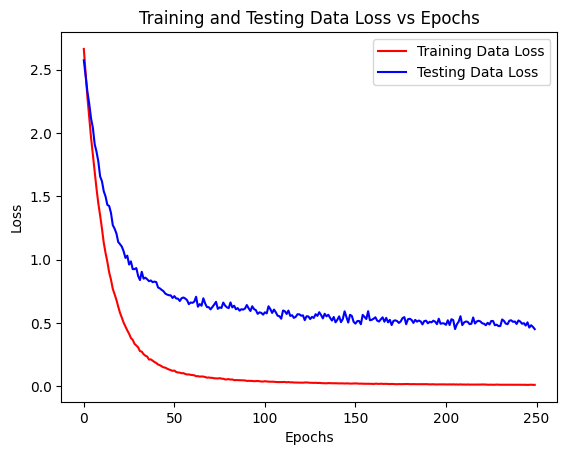

In [216]:
plt.plot(list(range(EPOCHS)),train_losses, c='r', label="Training Data Loss")
plt.plot(list(range(EPOCHS)),test_losses, c='b', label="Testing Data Loss")
plt.title("Training and Testing Data Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("training_testing_loss.png")
plt.show()

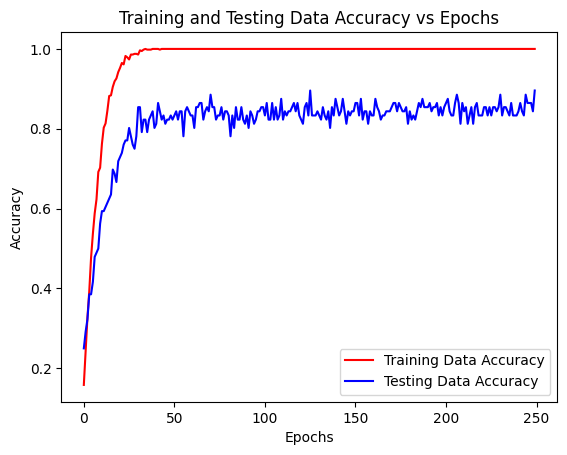

In [217]:
plt.plot(list(range(EPOCHS)),train_accs, c='r', label="Training Data Accuracy")
plt.plot(list(range(EPOCHS)),test_accs, c='b', label="Testing Data Accuracy")
plt.title("Training and Testing Data Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("training_testing_accuracy.png")
plt.show()

## Testing for one single point of the Training Data, printing the image

In [13]:
#Point testing

i = 140

test_x = torch.stack([imgs_train[i]], 0)
first, t_y = net(test_x)

print("Actual Label is : ", labels[i])
t_np = t_y.detach().numpy()
pred_label = np.argmax(t_np)
print("Predicted Label is : ", pred_label)
t_y_prob = torch.exp(t_y[0])
print((t_y_prob.detach().numpy())*100, "array of prob")
print(np.sum(t_y_prob.detach().numpy())*100, "sum of prob")

Actual Label is :  tensor(4)
Predicted Label is :  4
[2.56398227e-02 8.21622147e-04 4.25487608e-02 5.32857656e-01
 9.87037811e+01 7.57692615e-05 2.47453272e-01 3.78814749e-02
 1.20412435e-04 2.35979501e-02 4.53692192e-04 3.52839986e-03
 3.27314973e-01 4.33750711e-02 1.05520263e-02] array of prob
99.99999403953552 sum of prob


/opt/homebrew/lib/python3.10/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [108]:
im = Image.fromarray(np.uint8(imgs[i]))
im.show()

## Testing for all Training Points(that we trained our model with)

In [25]:
count = 0

for i in range(len(imgs)):
    test_x20 = torch.stack([imgs_train[i]], 0)
    first, t_y20 = net(test_x20)
    y_pred = t_y20.detach().numpy()
    l = np.argmax(y_pred)
    if(int(l)==int(labels[i])):
        count += 1
    if(len(y_pred[y_pred>-1])>1):
        print(i)
print(count)
print(count/len(imgs))


568
1.0


## Loading a saved model to use for testing purposes

In [218]:
#best model yet is "good_models_trained_uptil_now/model_log_softmax_15celeb_896dropoutpoint1_plus_L2_plus_batchnorm.pkl"
model = pkl.load(open('good_models_trained_uptil_now/model_log_softmax_15celeb_896dropoutpoint1_plus_L2_plus_batchnorm.pkl', 'rb'))

## Testing for all Test Points (change "net" to "model" if you loaded a model)

In [231]:
count = 0

for i in range(len(imgs_test)):
    test_x20 = torch.stack([imgs_test_final[i]], 0)
    first, t_y20 = model(test_x20)
    y_pred = t_y20.detach().numpy()
    l = np.argmax(y_pred)

    t_y_prob = torch.exp(t_y20[0])
    p = (t_y_prob.detach().numpy())*100
    if(float(np.max(p)) < 80):
        pass
        #print()
        #print(np.max(p), "max prob less than 80", i)
    # if(i==0):
    #     print(int(l), "Class for first")
    #     print(y_pred)
    if(int(l)!=int(labels_test[i])):
        count += 1
        # print(i, "ouch")
        # print(y_pred, "pred")
        # print(l , "pred res")
        # print(labels_test[i],"true")
        # print()
    
    # if(len(y_pred[y_pred>-1])>1):
    #     print(i,"more than 1")
print(count)
print(1 - (count/len(imgs_test)))

11
0.8854166666666666


In [230]:
print("Total Number of Test Images", len(imgs_test))
print("Number of Correctly Recognized Faces" , len(imgs_test) - count)
print("Number of Incorrectly Recognized Faces" , count)
print("Accuracy is", 100*(1 - (count/len(imgs_test))), "percent")


Total Number of Test Images 96
Number of Correctly Recognized Faces 85
Number of Incorrectly Recognized Faces 11
Accuracy is 88.54166666666666 percent


## Testing for one Test Point

In [247]:
#Point testing

i = 61

test_x = torch.stack([imgs_test_final[i]], 0)
first, t_y = model(test_x)

print("Actual Label is : ", labels_test[i])
t_np = t_y.detach().numpy()
pred_label = np.argmax(t_np)
print("Predicted Label is : ", pred_label)
t_y_prob = torch.exp(t_y[0])
print((t_y_prob.detach().numpy())*100, "array of prob")

Actual Label is :  tensor(10)
Predicted Label is :  10
[1.3906110e-02 4.2416959e-06 6.4272412e-05 2.6020972e-04 4.2462110e-05
 3.6313984e-05 6.1346713e-05 8.8515182e-05 1.0929608e-05 2.3339155e-04
 9.9953392e+01 2.2792287e-02 9.9684818e-05 8.2722912e-03 7.4319809e-04] array of prob


/opt/homebrew/lib/python3.10/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [250]:
im = Image.fromarray(np.uint8(imgs_test[i]))
im.show()

## Analysing Convolved Featues Produced by Test Point above

In [244]:
first = first.squeeze()
#first_f = first.permute(1,2,0)
print(first.shape)

import matplotlib.pyplot as plt

for i in range(64):
    plt.imsave("Convoluted_Features/f" + str(i) +".png", first[i].detach().numpy(), cmap=plt.get_cmap('gray'))


#im = Image.fromarray(np.uint8(first[1].detach()))
#im.show()

torch.Size([64, 13, 13])
